<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/u2netp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 背景除去モデルU<sup>2</sup>-Net (U-Square Net)を利用した葉面積定量

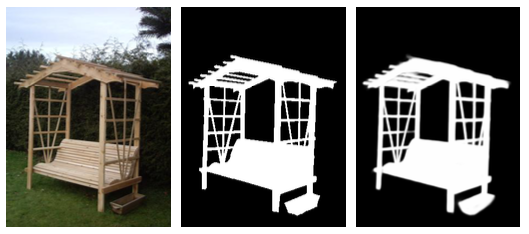

左から入力画像、真値、U<sup>2</sup>-Netによる推論結果<sup>1</sup>

## U<sup>2</sup>-Netとは
U<sup>2</sup>-Netは、2020年にPattern Recognitionで発表された論文において提唱されたモデルです。主な用途として、画像中の主要な撮影対象（salient object）の検出が挙げられます。公式レポジトリ<sup>2</sup>はApache 2.0ライセンスで公開されており、このモデルを使用して、U2-Netを基にした多くの興味深いアプリケーションやツールが開発されています。

今回は、そのうちの１つであるrembg<sup>3</sup>を紹介します。公式実装のpytorchモデルをonnxに変換し、pipでインストール可能なパッケージとして配布しされています。なお、rembg自体にはMITライセンスが付与されています。

以下の画像をU<sup>2</sup>-Netで推論させ、葉の領域を試みます。植物に特化して訓練されたモデルではありませんが、画像中のsalient objectが植物であれば単離できる可能性は高いと考えられます。


<center>
<img src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/Arabidopsis_arenosa_kz01.jpeg?raw=true" width=25%>

WIKIMEDIA COMMONS<sup>4</sup>. CC-BY-SA 4.0.
</center>

## 基本的な使い方
rembgライブラリをインストールします。
2023年６月現在、rembgはcpu動作版とgpu動作版が提供されています。
必要に応じ切り替えてください。


In [1]:
# !pip install rembg >/dev/null 2>&1  # cpu
!pip install rembg[gpu] >/dev/null 2>&1  # gpu

In [2]:
import cv2
from rembg import remove
from IPython.display import Image, display
import numpy as np

In [3]:
# jupyter notebookで画像を表示させるための関数。matplotlibのplt.imshowを使ってもらっても構いません。
def show_image(img):
    _, img = cv2.imencode(".jpg",img)
    display(Image(data=img))

--2023-07-27 05:43:03--  https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/imgs/Arabidopsis_arenosa_kz01.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79390 (78K) [image/jpeg]
Saving to: ‘image_1.jpg’

image_1.jpg         100%[===================>]  77.53K  --.-KB/s    in 0.01s   

2023-07-27 05:43:04 (6.11 MB/s) - ‘image_1.jpg’ saved [79390/79390]

(341, 512, 3)


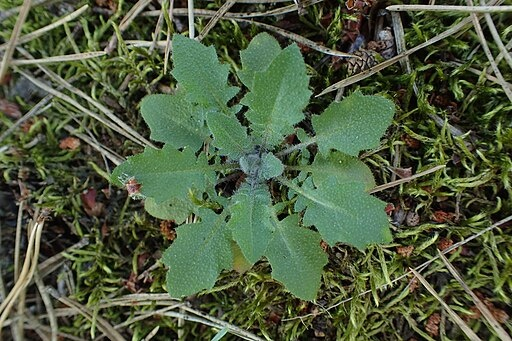

In [5]:
# 画像の取得
image_url_1 = 'https://raw.githubusercontent.com/phytometrics/plant_phenotyping_python/main/notebooks/imgs/Arabidopsis_arenosa_kz01.jpeg'
!wget -O image_1.jpg {image_url_1}
image = cv2.imread("image_1.jpg")
print(image.shape)
show_image(image)

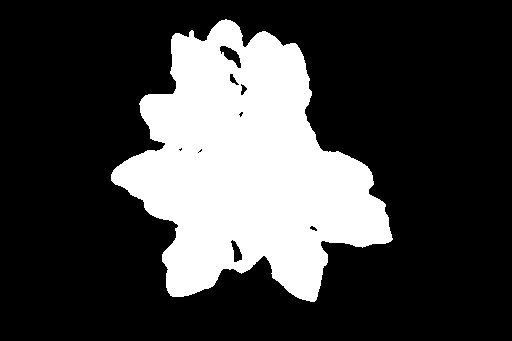

In [8]:
# 背景除去
mask = remove(image, only_mask=True)
# 0-255の輝度の値のうち、125を閾値にしてbool型に変換する。
mask = mask > 125
# bool型をuint8型（0-255）に戻す。
mask = mask.astype(np.uint8) * 255
# 画像を表示する。
show_image(mask)

In [13]:
#　葉面積を求めます。
# 2次元のmask画像を１次元に変換し、輝度が0ではないピクセル数の合計を求めます。
leaf_area = len(np.nonzero(mask.flatten())[0])
print(leaf_area, "px")

44981 px


## モデルの本来の用途とその限界を知る
上述の結果を見ると、葉面積定量に使える（かもしれない）モデルであるとの印象を受けます。しかしながら植物がsalient objectではない場合、どのような結果になるでしょうか？同じ画像に横方向移動処理をして、モデルで推論させてみましょう。

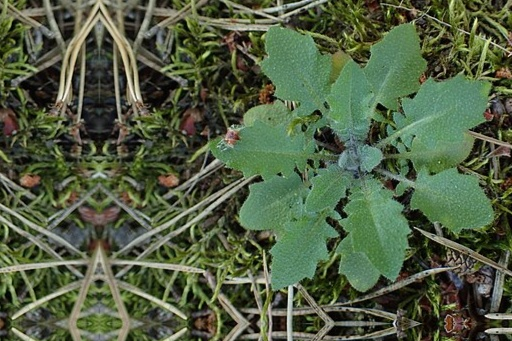

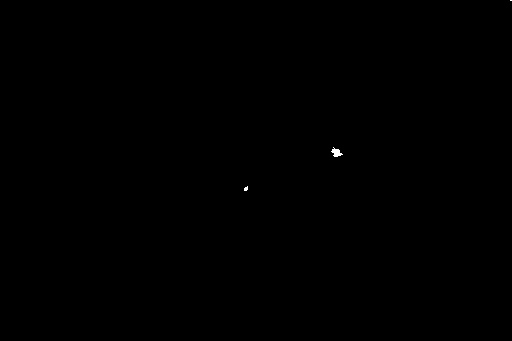

In [20]:
import albumentations as A

def shift(image, shift_x, shift_y):
    transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=(shift_x, shift_y), rotate_limit=0, scale_limit=0, p=1),
    ])
    shifted_image = transform(image=image)["image"]
    return shifted_image

# x方向シフト割合
shift_x = 5
# y方向シフト割合
shift_y = 0

# 今回はx軸方向のみへ画像をシフトさせます。
shifted_image = shift(image, shift_x, shift_y)

# 背景除去
mask = remove(shifted_image, only_mask=True)
# 0-255の輝度の値のうち、125を閾値にしてbool型に変換する。
mask = mask > 125
# bool型をuint8型（0-255）に戻す。
mask = mask.astype(np.uint8) * 255
# 画像を表示する。
show_image(shifted_image)
show_image(mask)

画像の中央に植物がなくなっただけで全く背景分離ができなくなりました。冒頭でも紹介したように、このモデルは画像中のsalient objectに対して背景分離を適用するために訓練されたモデルです。したがって、今回のように植物が画像中央からずれている場合、salient objectと認識されなくなったと推測されます。逆を言うと、salient objectの解析という条件を厳密に守る限り、モデルの再訓練無しに葉面積定量が行える、ということを示唆しています。

本稿で紹介したU<sup>2</sup>-Netに限らず、植物・農学ドメインの画像処理を目的とせず用意されたモデルであっても、**本来のユースケースで想定されるシーンにおいては**そのまま自信の解析パイプラインに使える可能性があるというお話でした。

## Citation

1. U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection, Qin et al., Pattern Recognition 2022.

2. https://github.com/xuebinqin/U-2-Net

3. https://github.com/danielgatis/rembg

4. https://commons.wikimedia.org/wiki/File:Arabidopsis_arenosa_kz01.jpg